<a href="https://colab.research.google.com/github/wwang93/JEDM-Paper-Pipeline/blob/main/JEDM_Manuscript_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
### update within your own file path

! cd "/content/drive/My Drive/JEDMSpeicalIssue/CrashCourse/GoldStandardValidation/NER_validation"
! ls "/content/drive/My Drive/JEDMSpeicalIssue/CrashCourse/GoldStandardValidation/NER_validation"

Mounted at /content/drive


# 1 Data and cleaning

##1.1 Download US-History Crash Course raw transcripts using yt-dlp

In [ ]:
# install yt-dlp
!pip install yt-dlp

In [ ]:
import os
import subprocess

# 1. Specify the YouTube playlist URL
playlist_url = "https://www.youtube.com/playlist?list=PL8dPuuaLjXtMwmepBjTSG593eG7ObzO7s"

# 2. Customize the channel and playlist names for output directory
channel_name = "CrashCourse"
playlist_title = "USHistory"

# 3. Define the output directory for subtitles
output_dir = f"/content/drive/My Drive/JEDMSpeicalIssue/{channel_name}/{playlist_title}_subs"
os.makedirs(output_dir, exist_ok=True)

# 4. Build the yt-dlp command to download English subtitles only (no video)
command = [
    "yt-dlp",
    "--ignore-errors",      # Continue on download errors
    "--yes-playlist",       # Download all videos in the playlist
    "--write-subs",         # Download subtitles
    "--sub-lang", "en",     # Subtitle language: English
    "--sub-format", "srt",  # Subtitle format: SRT
    "--skip-download",      # Do not download video/audio, only subs
    "-o", f"{output_dir}/%(title)s.%(ext)s",  # Output filename template
    playlist_url
]

# 5. Execute the command
print("Starting subtitles download using yt-dlp...")
print("Command:", " ".join(command))
result = subprocess.run(command, capture_output=True, text=True)

# 6. Provide user feedback
if result.returncode == 0:
    print("Subtitles download completed successfully!")
else:
    print("There was an error downloading subtitles.")
    print("Error details:")
    print(result.stderr)

## 1.2 transfer srt to txt file

In [ ]:
import os
import re

# 1. Define input (srt) and output (txt) directories
channel_name = "CrashCourse"
playlist_title = "USHistory"
srt_dir = f"/content/drive/My Drive/JEDMSpeicalIssue/{channel_name}/{playlist_title}_subs"
txt_dir = f"/content/drive/My Drive/JEDMSpeicalIssue/{channel_name}/{playlist_title}_txts"
os.makedirs(txt_dir, exist_ok=True)

# 2. SRT to TXT conversion function
def srt_to_txt(srt_path, txt_path):
    """
    Convert an .srt subtitle file to a plain .txt file by removing timestamps and serial numbers.
    Each subtitle segment is joined as a single line.
    """
    with open(srt_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    text_lines = []
    for line in lines:
        # Skip serial number lines (only digits)
        if re.match(r'^\d+\s*$', line):
            continue
        # Skip timestamp lines (start with 00:00:00,000)
        if re.match(r'^\d{2}:\d{2}:\d{2},\d{3}', line):
            continue
        if line.strip() == "":
            continue
        text_lines.append(line.strip())

    # Combine all text into one line; use '\n'.join(text_lines) if you prefer line breaks
    with open(txt_path, 'w', encoding='utf-8') as f:
        f.write(' '.join(text_lines))

# 3. Process all .srt files in the input directory
converted_count = 0
for fname in os.listdir(srt_dir):
    if fname.endswith(".srt"):
        srt_path = os.path.join(srt_dir, fname)
        txt_name = fname.replace(".srt", ".txt")
        txt_path = os.path.join(txt_dir, txt_name)
        srt_to_txt(srt_path, txt_path)
        print(f"Converted: {fname} --> {txt_name}")
        converted_count += 1

if converted_count == 0:
    print("No .srt files found in the source directory.")
else:
    print(f"All {converted_count} .srt files have been successfully converted to .txt format!")

##1.3 Using OPEN AI API key for coreference resolution



In [ ]:
!pip install openai tiktoken spacy

In [ ]:
import os
import time
import textwrap
import openai
import spacy

# ============ 2. Set the OpenAI API Key to an environment variable ============
os.environ["OPENAI_API_KEY"] = "YOUR OPENAI_API_KEY"
openai.api_key = os.environ["OPENAI_API_KEY"]

In [ ]:
# ============ Define coreference resolution and chunking functions ============

def resolve_coreferences_with_openai(text: str, model="gpt-4o"):
    """
    Calls the OpenAI API to resolve coreferences in the input text.
    Replaces each pronoun with the corresponding noun or name.
    """
    prompt = (
        "Below is a paragraph of text.\n"
        "Please replace each pronoun (he, she, they, etc.) with the correct noun or name it refers to.\n"
        "Keep all other words unchanged.\n\n"
        + text
    )
    try:
        response = openai.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are an assistant skilled in coreference resolution."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.0,
            top_p=1.0
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"[WARNING] OpenAI API error: {e}. Returning original text.")
        return text

def chunk_and_resolve(text: str, max_chars: int = 2000) -> str:
    """
    Chunks long texts by paragraph and resolves coreferences for each chunk using OpenAI.
    """
    paragraphs = text.split("\n\n")
    out = []
    for para in paragraphs:
        if not para.strip():
            continue
        if len(para) <= max_chars:
            out.append(resolve_coreferences_with_openai(para))
        else:
            # Ensure words are not split in the middle when chunking
            for chunk in textwrap.wrap(para, max_chars, break_long_words=False):
                out.append(resolve_coreferences_with_openai(chunk))
        # Sleep to avoid hitting the API rate limit
        time.sleep(0.5)
    return "\n\n".join(out)

# ============ Batch process txt files, support resume from breakpoint, save to new folder ============

channel_name = "CrashCourse"
playlist_title = "USHistory"
txt_dir = f"/content/drive/My Drive/JEDMSpeicalIssue/{channel_name}/{playlist_title}_txts"
txt_coref_dir = f"/content/drive/My Drive/JEDMSpeicalIssue/{channel_name}/{playlist_title}_coreferenced_txts"
os.makedirs(txt_coref_dir, exist_ok=True)

for fname in os.listdir(txt_dir):
    if fname.endswith('.txt'):
        coref_path = os.path.join(txt_coref_dir, fname)
        if os.path.exists(coref_path):
            print(f"[SKIP] Already processed: {fname}")
            continue

        txt_path = os.path.join(txt_dir, fname)
        with open(txt_path, 'r', encoding='utf-8') as f:
            text = f.read()
        coref_text = chunk_and_resolve(text)
        with open(coref_path, 'w', encoding='utf-8') as f:
            f.write(coref_text)
        print(f"[SUCCESS] Coreference resolved and saved: {fname}")

print("All .txt files have been processed and coreference-resolved versions have been saved.")


## 1.4 Using OPENAI API for NER Enhancement

In [ ]:
# ============ Define NER Enhancement Function ============

def resolve_NER_with_openai(text: str, model="gpt-4o"):
    """
    Uses OpenAI GPT-4o for Named Entity Recognition (NER) and coreference resolution,
    with a focus on American history. The function identifies, corrects, and standardizes
    named entities in the transcript.
    """
    prompt = (
        "You are an expert in advanced Named Entity Recognition (NER). "
        "You will be given the full transcript of a video subtitle file. "
        "Your job is to carefully review the entire text and ensure that all named entities are correctly identified and accurately standardized, focusing on the following entity types:\n"
        "PERSON: Historical or public figures (e.g., 'Abraham Lincoln', 'Frederick Douglass').\n"
        "ORG: Organizations, institutions, or historical groups (e.g., 'Continental Congress', 'Supreme Court').\n"
        "GPE: Countries, cities, or regions (e.g., 'United States', 'Virginia').\n"
        "LOC: Geographic locations that are not geopolitical (e.g., 'Appalachian Mountains', 'Mississippi River').\n"
        "NORP: Nationalities, religious groups, or political groups (e.g., 'Unionists', 'Quakers', 'Republicans').\n"
        "EVENT: Named historical events (e.g., 'Civil War', 'Boston Tea Party').\n"
        "LAW: Historical legal documents or acts (e.g., 'Emancipation Proclamation', 'Bill of Rights').\n\n"
        "Instructions:\n"
        "1. For each entity above, correct any errors, misspellings, abbreviations, or ambiguous mentions, replacing them with the full, precise, and canonical historical name.\n"
        "2. Replace pronouns or vague references with their explicit entity name only when the reference is clear.\n"
        "3. Do not change any other text. Do not add explanations, comments, tags, or notes.\n"
        "4. Output only the corrected full transcript, preserving the original format and line breaks. Your output should be a fully corrected subtitle file ready for saving as a .txt file.\n\n"
        "Text to review:\n"
        + text
    )
    try:
        response = openai.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are an expert in American history and advanced Named Entity Recognition (NER)."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.0,
            top_p=1.0
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"[WARNING] OpenAI API error: {e}. Returning original text.")
        return text

def chunk_and_resolve(text: str, max_chars: int = 2000) -> str:
    """
    Chunks long text by paragraphs and applies OpenAI NER to each chunk.
    """
    paragraphs = text.split("\n\n")
    out = []
    for para in paragraphs:
        if not para.strip():
            continue
        if len(para) <= max_chars:
            out.append(resolve_NER_with_openai(para))
        else:
            # Ensure words are not split in the middle when chunking
            for chunk in textwrap.wrap(para, max_chars, break_long_words=False):
                out.append(resolve_NER_with_openai(chunk))
        # Sleep to avoid hitting the API rate limit
        time.sleep(0.5)
    return "\n\n".join(out)

# ============ Batch process txt files, support resume from breakpoint, save to new folder ============

channel_name = "CrashCourse"
playlist_title = "USHistory"
txt_dir = f"/content/drive/My Drive/JEDMSpeicalIssue/{channel_name}/{playlist_title}_raw_txts"
txt_coref_dir = f"/content/drive/My Drive/JEDMSpeicalIssue/{channel_name}/{playlist_title}_LLMsNER_txts"
os.makedirs(txt_coref_dir, exist_ok=True)

for fname in os.listdir(txt_dir):
    if fname.endswith('.txt'):
        coref_path = os.path.join(txt_coref_dir, fname)
        if os.path.exists(coref_path):
            print(f"[SKIP] Already processed: {fname}")
            continue

        txt_path = os.path.join(txt_dir, fname)
        with open(txt_path, 'r', encoding='utf-8') as f:
            text = f.read()
        coref_text = chunk_and_resolve(text)
        with open(coref_path, 'w', encoding='utf-8') as f:
            f.write(coref_text)
        print(f"[SUCCESS] NER resolved and saved: {fname}")

print("All .txt files have been processed and NER-enhanced versions have been saved.")


#2 RQ1: comparsion across different ASR

##2.1 USE human transcript as gold standard for Research question1

In [ ]:
# Install JiWer python package and visual dependency
!pip install --upgrade jiwer
!pip install jiwer matplotlib

                     WER       MER       WIL       CER
ASR_TurboScibe  0.024300  0.024185  0.037584  0.009976
ASR_Whisper     0.034242  0.034029  0.052390  0.013967
ASR_Ytdlp       0.035714  0.035234  0.048947  0.020725
ASR_Otter       0.041605  0.041031  0.061720  0.012165
ASR_Vosk        0.153166  0.146945  0.228402  0.086246


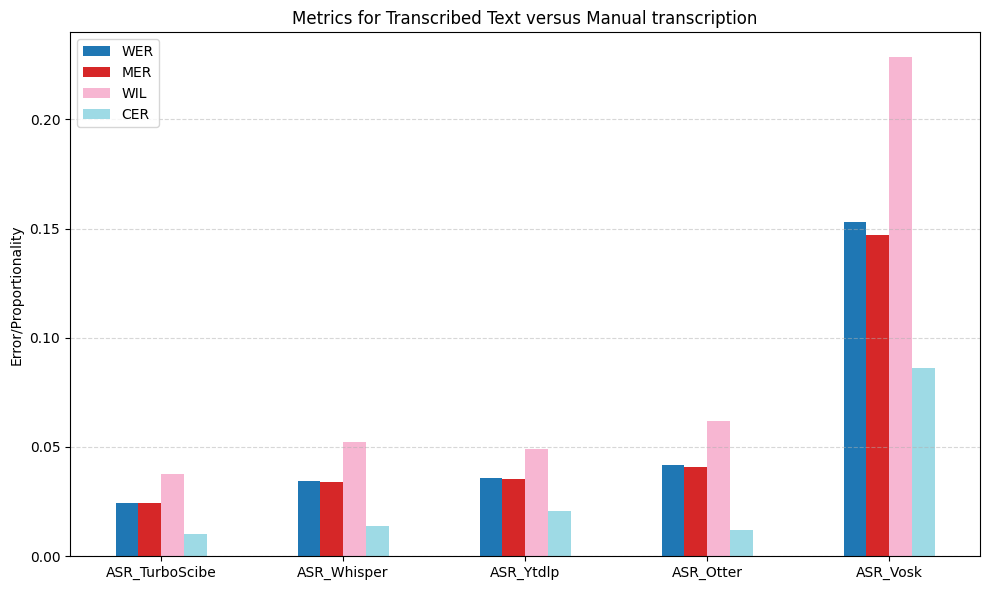

In [ ]:
import os
from jiwer import wer, mer, wil, wip, cer, Compose, ToLowerCase, RemovePunctuation, RemoveMultipleSpaces, Strip
import matplotlib.pyplot as plt
import pandas as pd

# 1. file path
folder = "/content/drive/My Drive/JEDMSpeicalIssue/CrashCourse/GoldStandardValidation"
base_name = "The Reagan Revolution： Crash Course US History #43.en.txt"

files = {
    "ASR_Ytdlp":     os.path.join(folder, f"Raw_{base_name}"),
    "ASR_Whisper":   os.path.join(folder, f"Whisper_{base_name}"),
    "ASR_Vosk":    os.path.join(folder, f"Vosk_{base_name}"),
    "ASR_TurboScibe":    os.path.join(folder, f"TurboScibe_{base_name}"),
    "ASR_Otter":    os.path.join(folder, f"Otter_{base_name}"),
    "Human":         os.path.join(folder, f"Human_{base_name}"),

}

# 2. read texts
texts = {}
for key, path in files.items():
    with open(path, "r", encoding="utf-8") as f:
        texts[key] = f.read()

# 3. Define a standardized preprocessing pipeline for jiwer
transformation = Compose([
    ToLowerCase(),
    RemovePunctuation(),
    RemoveMultipleSpaces(),
    Strip(),
])

# 4. Caculate Jiwer indicators
results = {}
for k in ["ASR_Whisper", "ASR_Ytdlp", "ASR_Vosk", "ASR_Otter", "ASR_TurboScibe"]:
    truth = transformation(texts["Human"])
    hypo = transformation(texts[k])
    results[k] = {
        "WER": wer(truth, hypo),
        "MER": mer(truth, hypo),
        "WIL": wil(truth, hypo),
        "WIP": wip(truth, hypo),
        "CER": cer(truth, hypo),
    }

# 5. Summary table
# Sort by WER ascending
df = pd.DataFrame(results).T
df_sorted = df.sort_values(by="WER", ascending=True)
df_sorted = df_sorted[["WER", "MER", "WIL", "CER"]]
print(df_sorted)

# 6. plots
fig, ax = plt.subplots(figsize=(10, 6))
df_sorted.plot(kind="bar", ax=ax, rot=0, colormap='tab20')
plt.title("Metrics for Transcribed Text versus Manual transcription")
plt.ylabel("Error/Proportionality")
plt.xlabel("")
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# save as png in the /content/drive/My Drive/JEDMSpeicalIssue
plt.savefig("/content/drive/My Drive/JEDMSpeicalIssue/CrashCourse/Metrics_for_Transcribed_Text_versus_Manual_transcription.png")
plt.show()





#3 RQ2 : What are the effects of employing LLM-based cleaning processes on ASR-generated transcripts, in terms of named entity recognition?

### Selected 4 random sample video NER validation

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ============ Define target folders and base directory ============
folders = [
    "Great_Depression",
    "Reagan_Revolution",
    "War_Expansion",
    "US_Politics"
]
base_dir = "/content/drive/My Drive/JEDMSpeicalIssue/CrashCourse/GoldStandardValidation/NER_validation/Single_validation"

# ============ Initialize data storage lists ============
asr_list, llms_core_list, llms_ner_list, gold_list = [], [], [], []

# ============ Read and aggregate data from each folder ============
for folder in folders:
    asr_path = os.path.join(base_dir, folder, "ASRNER.csv")
    llms_core_path = os.path.join(base_dir, folder, "LLMscore.csv")
    llms_ner_path = os.path.join(base_dir, folder, "LLMsNER.csv")
    gold_path = os.path.join(base_dir, folder, "GoldNER.csv")

    asr = pd.read_csv(asr_path)
    asr["video_name"] = folder

    llms_core = pd.read_csv(llms_core_path)
    llms_core["video_name"] = folder

    llms_ner = pd.read_csv(llms_ner_path)
    llms_ner["video_name"] = folder

    gold = pd.read_csv(gold_path)
    gold["video_name"] = folder

    asr_list.append(asr)
    llms_core_list.append(llms_core)
    llms_ner_list.append(llms_ner)
    gold_list.append(gold)

# ============ Concatenate data from all folders ============
asr_df = pd.concat(asr_list, ignore_index=True)
llms_core_df = pd.concat(llms_core_list, ignore_index=True)
llms_ner_df = pd.concat(llms_ner_list, ignore_index=True)
gold_df = pd.concat(gold_list, ignore_index=True)

# ============ Normalize for case and whitespace ============
def normalize(s):
    """Convert to lowercase and strip whitespace for fair comparison."""
    return str(s).strip().lower()

for df in [asr_df, llms_core_df, llms_ner_df, gold_df]:
    df['entity_norm'] = df['entity'].apply(normalize)
    df['ner_type_norm'] = df['ner_type'].apply(normalize)

# ============ Metric Calculation Function ============
def entity_level_metrics(pred_df, gold_df, name="Model"):
    """
    Calculate entity-level NER metrics (precision, recall, F1, accuracy).
    """
    pred_set = set(zip(pred_df['entity_norm'], pred_df['ner_type_norm']))
    gold_set = set(zip(gold_df['entity_norm'], gold_df['ner_type_norm']))
    TP = len(pred_set & gold_set)
    FP = len(pred_set - gold_set)
    FN = len(gold_set - pred_set)
    # No TN, accuracy is TP / (TP+FP+FN)
    acc = TP / (TP + FP + FN) if (TP + FP + FN) else 0
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    print(f"\n{name} entity-level NER (aggregated over all videos)")
    print(f"TP: {TP}  FP: {FP}  FN: {FN}")
    print(f"Accuracy: {acc:.3f}  Precision: {precision:.3f}  Recall: {recall:.3f}  F1: {f1:.3f}")
    return dict(model=name, TP=TP, FP=FP, FN=FN, accuracy=acc, precision=precision, recall=recall, f1=f1)

# ============ Global (all videos) entity-level metrics ============
results = []
results.append(entity_level_metrics(asr_df, gold_df, "ASR"))
results.append(entity_level_metrics(llms_core_df, gold_df, "LLMs_Coref"))
results.append(entity_level_metrics(llms_ner_df, gold_df, "LLMs_NER"))
results_df = pd.DataFrame(results)
print("\nSummary comparison (all methods):")
print(results_df[['model', 'accuracy', 'precision', 'recall', 'f1']])

# ============ Per NER Type Comparison ============
ner_types = sorted(set(gold_df['ner_type_norm']) | set(asr_df['ner_type_norm']) |
                   set(llms_core_df['ner_type_norm']) | set(llms_ner_df['ner_type_norm']))

by_type = []
for nt in ner_types:
    asr_sub = asr_df[asr_df['ner_type_norm'] == nt]
    llms_core_sub = llms_core_df[llms_core_df['ner_type_norm'] == nt]
    llms_ner_sub = llms_ner_df[llms_ner_df['ner_type_norm'] == nt]
    gold_sub = gold_df[gold_df['ner_type_norm'] == nt]
    asr_result = entity_level_metrics(asr_sub, gold_sub, f"ASR - {nt.upper()}")
    llms_core_result = entity_level_metrics(llms_core_sub, gold_sub, f"LLMs_Coref - {nt.upper()}")
    llms_ner_result = entity_level_metrics(llms_ner_sub, gold_sub, f"LLMs_NER - {nt.upper()}")
    by_type.append({
        "ner_type": nt.upper(),
        "asr_acc": asr_result["accuracy"], "asr_precision": asr_result["precision"], "asr_recall": asr_result["recall"], "asr_f1": asr_result["f1"],
        "llms_coref_acc": llms_core_result["accuracy"], "llms_coref_precision": llms_core_result["precision"], "llms_coref_recall": llms_core_result["recall"], "llms_coref_f1": llms_core_result["f1"],
        "llms_ner_acc": llms_ner_result["accuracy"], "llms_ner_precision": llms_ner_result["precision"], "llms_ner_recall": llms_ner_result["recall"], "llms_ner_f1": llms_ner_result["f1"]
    })

by_type_df = pd.DataFrame(by_type)
print("\n=== Entity-level NER comparison by type (aggregated over all videos) ===")
print(by_type_df)

# ============ Visualization: F1-score by Method and NER Type ============
plt.figure(figsize=(11, 6))
bar_width = 0.22
index = range(len(by_type_df))
plt.bar(index, by_type_df['asr_f1'], bar_width, label='ASR F1', alpha=0.85)
plt.bar([i + bar_width for i in index], by_type_df['llms_coref_f1'], bar_width, label='LLMs Coref F1', alpha=0.85)
plt.bar([i + 2 * bar_width for i in index], by_type_df['llms_ner_f1'], bar_width, label='LLMs NER F1', alpha=0.85)
plt.xticks([i + bar_width for i in index], by_type_df['ner_type'], rotation=45)
plt.xlabel('NER Type')
plt.ylabel('F1-score')
plt.title('Entity-level NER F1 by Method and Type (All Videos)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# ============ Visualization: Compare Accuracy, Precision, Recall by NER Type and Method ============

# Loop over each metric to plot (Accuracy, Precision, Recall)
for metric, col_suffix in zip(
    ["accuracy", "precision", "recall"],
    ["acc", "precision", "recall"]
):
    plt.figure(figsize=(11, 6))
    plt.bar(index, by_type_df[f'asr_{col_suffix}'], bar_width, label='ASR', alpha=0.85)
    plt.bar([i + bar_width for i in index], by_type_df[f'llms_coref_{col_suffix}'], bar_width, label='LLMs Coref', alpha=0.85)
    plt.bar([i + 2 * bar_width for i in index], by_type_df[f'llms_ner_{col_suffix}'], bar_width, label='LLMs NER', alpha=0.85)
    plt.xticks([i + bar_width for i in index], by_type_df['ner_type'], rotation=45)
    plt.xlabel('NER Type')
    plt.ylabel(metric.capitalize())
    plt.title(f'Entity-level NER {metric.capitalize()} by Method and Type (All Videos)')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:

# ============ Bar Chart Comparison for Accuracy, Precision, Recall by NER Type ============

for metric, col_suffix in zip(
    ["accuracy", "precision", "recall"],
    ["acc", "precision", "recall"]
):
    # Exclude NER types that are not of interest
    mask = ~by_type_df['ner_type'].isin(['FAC', 'LANGUAGE', 'WORK_OF_ART'])
    df_plot = by_type_df[mask].reset_index(drop=True)
    index = range(len(df_plot))

    plt.figure(figsize=(11, 6))
    plt.bar(index, df_plot[f'asr_{col_suffix}'], bar_width, label='ASR', alpha=0.85)
    plt.bar([i + bar_width for i in index], df_plot[f'llms_coref_{col_suffix}'], bar_width, label='LLMs Coref', alpha=0.85)
    plt.bar([i + 2 * bar_width for i in index], df_plot[f'llms_ner_{col_suffix}'], bar_width, label='LLMs NER', alpha=0.85)
    plt.xticks([i + bar_width for i in index], df_plot['ner_type'], rotation=45)
    plt.xlabel('NER Type')
    plt.ylabel(metric.capitalize())
    plt.title(f'NER {metric.capitalize()} by Method and Type')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
overall = results_df[['model', 'accuracy', 'precision', 'recall', 'f1']]
print(overall.round(3).to_markdown(index=False))

In [ ]:
cols = [
    "ner_type",
    "asr_acc", "asr_precision", "asr_recall", "asr_f1",
    "llms_coref_acc", "llms_coref_precision", "llms_coref_recall", "llms_coref_f1",
    "llms_ner_acc", "llms_ner_precision", "llms_ner_recall", "llms_ner_f1"
]
print(by_type_df[cols].round(3).to_markdown(index=False))


# 4 RQ3: How can LLMs transcript be better when do qual(topic modeling)

### Step 1 PyLDAvis Vis Comparsion

In [ ]:
!pip install gensim pyLDAvis nltk wordcloud matplotlib
import os
import glob
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim import corpora, models
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
!pip install spacy gensim pyLDAvis wordcloud
import spacy
import os
import glob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim import corpora, models
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def spacy_tokenize(text):
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and len(token) > 2]

def load_corpus_spacy(dir_path):
    texts = []
    filenames = sorted(glob.glob(os.path.join(dir_path, "*.txt")))
    for fname in filenames:
        with open(fname, "r", encoding="utf-8") as f:
            text = f.read()
            texts.append(spacy_tokenize(text))
    return texts, filenames


In [ ]:
# data path
data_dirs = {
    "ASR": "/content/drive/My Drive/JEDMSpeicalIssue/CrashCourse/USHistory_raw_txts",
    "LLMs_Coref": "/content/drive/My Drive/JEDMSpeicalIssue/CrashCourse/USHistory_LLMs_coreferenced_txts",
    "LLLMs_NER": "/content/drive/My Drive/JEDMSpeicalIssue/CrashCourse/USHistory_LLMsNER_txts"

}
NUM_TOPICS = 5
results = {}

for version, dir_path in data_dirs.items():
    print(f"\n=== {version} ===")
    texts, fnames = load_corpus_spacy(dir_path)
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(t) for t in texts]
    lda = models.LdaModel(corpus, id2word=dictionary, num_topics=NUM_TOPICS, random_state=42, passes=10)
    results[version] = {
        "lda": lda,
        "corpus": corpus,
        "dictionary": dictionary,
        "texts": texts
    }

In [ ]:
# data path
data_dirs = {
    "ASR": "/content/drive/My Drive/JEDMSpeicalIssue/CrashCourse/USHistory_raw_txts",
    "LLMs_Coref": "/content/drive/My Drive/JEDMSpeicalIssue/CrashCourse/USHistory_LLMs_coreferenced_txts",
    "LLLMs_NER": "/content/drive/My Drive/JEDMSpeicalIssue/CrashCourse/USHistory_LLMsNER_txts"

}
NUM_TOPICS = 5
results = {}

for version, dir_path in data_dirs.items():
    print(f"\n=== {version} ===")
    texts, fnames = load_corpus_spacy(dir_path)
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(t) for t in texts]
    lda = models.LdaModel(corpus, id2word=dictionary, num_topics=NUM_TOPICS, random_state=42, passes=10)
    results[version] = {
        "lda": lda,
        "corpus": corpus,
        "dictionary": dictionary,
        "texts": texts
    }

In [ ]:
version = "ASR"
vis = gensimvis.prepare(
    results[version]["lda"],
    results[version]["corpus"],
    results[version]["dictionary"]
)
pyLDAvis.display(vis)


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

version = "LLMs_Coref"
vis = gensimvis.prepare(
    results[version]["lda"],
    results[version]["corpus"],
    results[version]["dictionary"]
)
pyLDAvis.display(vis)


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

version = "LLLMs_NER"
vis = gensimvis.prepare(
    results[version]["lda"],
    results[version]["corpus"],
    results[version]["dictionary"]
)
pyLDAvis.display(vis)

In [ ]:
import os
import spacy

folder = "/content/drive/My Drive/JEDMSpeicalIssue/CrashCourse/GoldStandardValidation"
base_name = "The Reagan Revolution： Crash Course US History #43.en.txt"

files = {
    "ASR_TurboScibe": os.path.join(folder, f"TurboScibe_{base_name}"),
    "Defined_Uncontract": os.path.join(folder, f"Uncontracted_{base_name}"),
    "LLMs_Coref": os.path.join(folder, f"Coreferenced_{base_name}"),
    "Human": os.path.join(folder, f"Human_{base_name}"),
}

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
def spacy_tokenize(text):
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and len(token) > 2]

texts = {}
for k, path in files.items():
    with open(path, "r", encoding="utf-8") as f:
        texts[k] = f.read()


In [ ]:
from gensim import corpora, models
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

NUM_TOPICS = 4

lda_results = {}

for k, raw_text in texts.items():
    tokens = spacy_tokenize(raw_text)
    doc_chunks = [tokens[i:i+100] for i in range(0, len(tokens), 100)]
    dictionary = corpora.Dictionary(doc_chunks)
    corpus = [dictionary.doc2bow(chunk) for chunk in doc_chunks]
    lda = models.LdaModel(corpus, id2word=dictionary, num_topics=NUM_TOPICS, passes=10, random_state=42)
    lda_results[k] = {"lda": lda, "corpus": corpus, "dictionary": dictionary}


In [ ]:
version = "ASR_TurboScibe"
vis = gensimvis.prepare(lda_results[version]["lda"], lda_results[version]["corpus"], lda_results[version]["dictionary"])
pyLDAvis.display(vis)


In [ ]:
version = "LLMs_Coref"
vis = gensimvis.prepare(lda_results[version]["lda"], lda_results[version]["corpus"], lda_results[version]["dictionary"])
pyLDAvis.display(vis)

### Step2 Reagan Revolution Narritive NER Validation

In [ ]:
import pandas as pd

# 1. Gold standard: NER wide table (dict: NER type → list of canonical entities)
gold_dict = {
    "PERSON": ["Ronald Reagan", "Jimmy Carter", "George HW Bush", "Mikhail Gorbachev", "Nancy Reagan", "John Poindexter", "Oliver North"],
    "ORG": ["Congress", "Moral Majority", "Supreme Court", "NATO", "Reagan administration", "Sandinista government", "Crash Course"],
    "GPE": ["America", "US", "Soviet Union", "Illinois", "New York", "Western Europe", "France", "Lebanon", "Nicaragua"],
    "LOC": ["Iron Curtain"],
    "NORP": ["American", "African Americans", "conservatives", "religious conservatives", "economic conservatives", "Cold War hawks", "Christian right", "anti-government crusaders", "Democratic", "Soviet", "Iranian", "Middle Eastern"],
    "EVENT": ["Reagan Revolution", "Cold War", "Iran-Contra Scandal", "New Deal", "Great Society", "Korean", "Vietnam wars", "1960s", "1970s", "1980s", "mid-1990s", "atomic age", "FREEZE movement"],
    "LAW": ["Economic Bill of Rights", "Tax Reform Act", "Anti-ballistic Missile Treaty"]
}

# 2. System NER output file mapping
base_dir = "/content/drive/My Drive/JEDMSpeicalIssue/CrashCourse/GoldStandardValidation/NER_validation/Single_validation/Reagan_Revolution"
system_files = {
    "ASR":      "ASRNER.csv",
    "LLMsCoref":"LLMscoreNER.csv",
    "LLMsNER":  "LLMs_NER.csv"
}

# 3. Helper function for normalization
def normalize(s):
    """Lowercase and strip input string for robust matching."""
    return str(s).strip().lower()

results_summary = []
detailed_rows = []

# 4. Iterate over systems and calculate per-type and per-entity metrics
for version, filename in system_files.items():
    df = pd.read_csv(f"{base_dir}/{filename}")
    df['entity_norm'] = df['entity'].apply(normalize)
    df['ner_type_norm'] = df['ner_type'].apply(normalize)

    # Build predicted set for each type, then compute metrics
    for ner_type in gold_dict:
        pred_set = set(df[df['ner_type_norm'] == ner_type.lower()]['entity_norm'])
        gold_set = set(normalize(e) for e in gold_dict[ner_type])

        TP = len(pred_set & gold_set)
        FP = len(pred_set - gold_set)
        FN = len(gold_set - pred_set)
        precision = TP / (TP + FP) if (TP + FP) else 0
        recall = TP / (TP + FN) if (TP + FN) else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
        accuracy = TP / (TP + FP + FN) if (TP + FP + FN) else 0

        results_summary.append({
            "system": version,
            "ner_type": ner_type,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "TP": TP, "FP": FP, "FN": FN
        })

        # Per-entity details: whether the system recognized this gold entity
        for e in gold_dict[ner_type]:
            detailed_rows.append({
                "system": version,
                "ner_type": ner_type,
                "entity": e,
                "recognized": "✓" if normalize(e) in pred_set else "✗"
            })

# 5. DataFrames for summary and details
summary_df = pd.DataFrame(results_summary)
detail_df = pd.DataFrame(detailed_rows)

# 6. Macro-average (by NER type) for each system
macro_df = summary_df.groupby("system")[["precision", "recall", "f1"]].mean().reset_index()
print("=== Macro-average Precision/Recall/F1 across NER types ===")
print(macro_df.round(3))

# 7. Detailed per-entity recognition table
for version in system_files.keys():
    print(f"\n--- {version} Recognized Entities (by gold reference) ---")
    print(detail_df[detail_df['system'] == version][["ner_type", "entity", "recognized"]].to_markdown(index=False))

# 8. Save summary and detail tables if needed
summary_df.to_csv(f"{base_dir}/ner_strict_eval_summary.csv", index=False)
detail_df.to_csv(f"{base_dir}/ner_strict_eval_detail.csv", index=False)


=== Macro Average Scores ===
     version  precision  recall     f1
0        ASR      0.248   0.345  0.272
1  LLMsCoref      0.291   0.393  0.301
2    LLMsNER      0.734   0.989  0.815

--- ASR Recognized Entities ---
| ner_type   | entity                        | recognized   |
|:-----------|:------------------------------|:-------------|
| PERSON     | Ronald Reagan                 | ✓            |
| PERSON     | Jimmy Carter                  | ✓            |
| PERSON     | George HW Bush                | ✗            |
| PERSON     | Mikhail Gorbachev             | ✓            |
| PERSON     | Nancy Reagan                  | ✗            |
| PERSON     | John Poindexter               | ✓            |
| PERSON     | Oliver North                  | ✓            |
| ORG        | Congress                      | ✓            |
| ORG        | Moral Majority                | ✗            |
| ORG        | Supreme Court                 | ✗            |
| ORG        | NATO                   